# Load Data

In [210]:
import arviz as az
import numpy as np
import pandas as pd
import pymc as pm
import scipy.stats as sts
from scipy.special import logsumexp
import matplotlib.pyplot as plt
import seaborn as sns

In [260]:
# Load dataset
gov_exp = pd.read_csv("Real General Government Final Consumption Expenditure for Argentina.csv")
x = gov_exp["NCGGRSAXDCARQ"].values

gdp = pd.read_csv("Real Gross Domestic Product for Argentina.csv")
y = gdp["NGDPRSAXDCARQ"].values

# Create a dataframe
df = pd.DataFrame({"government_expenditure": x, "real_gdp": y})
df.head()

,government_expenditure,real_gdp
0,13157.099609,118996.898438
1,13216.700195,117536.703125
2,13618.000000,123438.601562
3,13927.000000,125143.101562
4,14386.799805,128751.203125


In [212]:
date = gov_exp["DATE"]
df_date = pd.DataFrame({"date":date, "government_expenditure": x, "real_gdp": y})
df_date.head()

,date,government_expenditure,real_gdp
0,2004-01-01,13157.099609,118996.898438
1,2004-04-01,13216.700195,117536.703125
2,2004-07-01,13618.000000,123438.601562
3,2004-10-01,13927.000000,125143.101562
4,2005-01-01,14386.799805,128751.203125


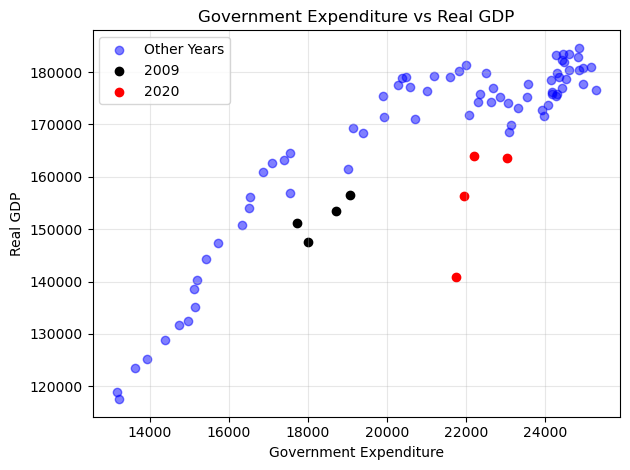

In [213]:
def plot_gdp_expenditure(df):
    # Create a copy to avoid modifying the original dataframe
    df_plot = df_date.copy()
    
    # Convert date strings to datetime objects
    df_plot['date'] = pd.to_datetime(df_plot['date'])
    
    # Create boolean masks for 2019 and 2020 data
    mask_2020 = df_plot['date'].dt.year == 2020
    mask_2019 = df_plot['date'].dt.year == 2009
    mask_other = ~(mask_2019 | mask_2020)  # All other years
    
    # Plot other years data points
    plt.scatter(df_plot[mask_other]['government_expenditure'], 
               df_plot[mask_other]['real_gdp'], 
               color='blue', 
               label='Other Years', 
               alpha=0.5)
    
    # Plot 2019 data points
    if mask_2019.any():  # Only plot if there are 2019 points
        plt.scatter(df_plot[mask_2019]['government_expenditure'], 
                   df_plot[mask_2019]['real_gdp'], 
                   color='black', 
                   label='2009')
    
    # Plot 2020 data points
    if mask_2020.any():  # Only plot if there are 2020 points
        plt.scatter(df_plot[mask_2020]['government_expenditure'], 
                   df_plot[mask_2020]['real_gdp'], 
                   color='red', 
                   label='2020')
    
    # Customize the plot
    plt.xlabel('Government Expenditure')
    plt.ylabel('Real GDP')
    plt.title('Government Expenditure vs Real GDP')
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    # Show the plot
    plt.tight_layout()
    plt.show()

# Example usage with your dataframe:
plot_gdp_expenditure(df)

Text(0.5, 1.0, 'Government Expenditure vs Gross Domestic Product')

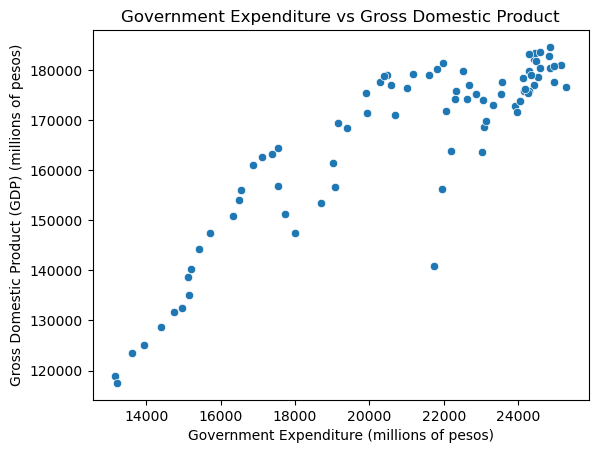

In [214]:
sns.scatterplot(x=x, y=y)  
plt.xlabel("Government Expenditure (millions of pesos)")
plt.ylabel("Gross Domestic Product (GDP) (millions of pesos)")
plt.title("Government Expenditure vs Gross Domestic Product")

In [261]:
df['gov_exp_std'] = (df['government_expenditure'] - df['government_expenditure'].mean()) / df['government_expenditure'].std()
df['gdp_std'] = (df['real_gdp'] - df['real_gdp'].mean()) / df['real_gdp'].std()
x = df['gov_exp_std'].values
y = df['gdp_std'].values

Text(0.5, 1.0, 'Government Expenditure vs Gross Domestic Product')

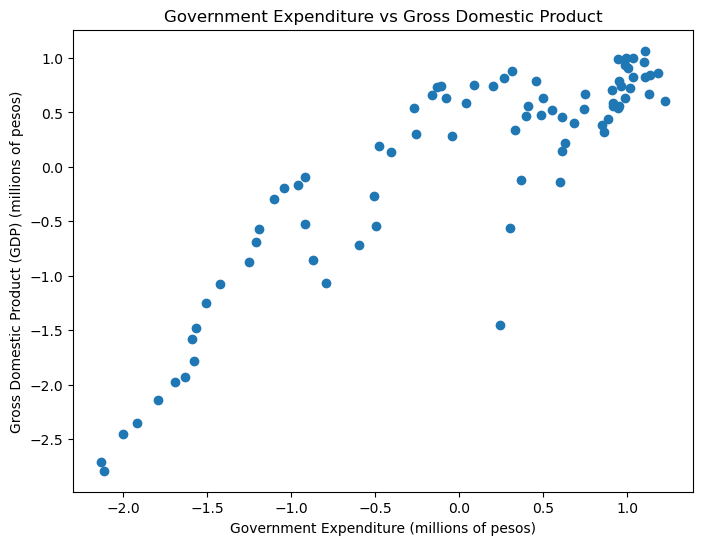

In [216]:
plt.figure(figsize=(8, 6))
plt.scatter(x, y)
plt.xlabel("Government Expenditure (millions of pesos)")
plt.ylabel("Gross Domestic Product (GDP) (millions of pesos)")
plt.title("Government Expenditure vs Gross Domestic Product")

In [217]:
data_x = (df['government_expenditure'] - df['government_expenditure'].mean()) / df['government_expenditure'].std()
data_y = (df['real_gdp'] - df['real_gdp'].mean()) / df['real_gdp'].std()
index = np.argsort(data_x)
data_x = data_x[index]
data_y = data_y[index]

# Normal Model

In [218]:
print('Fitting linear model')
with pm.Model() as model_1:
    a = pm.Uniform('a', lower=0, upper=20)
    b = pm.Normal('b', mu=0, sigma=1)
    sigma = pm.HalfNormal('sigma', 5)
    mu = pm.Deterministic('mu', a + b * data_x)
    y = pm.Normal('y', mu=mu, sigma=sigma, observed=data_y)
    inference_1 = pm.sample()
    pm.compute_log_likelihood(inference_1)
az.summary(inference_1, var_names="~mu")

Fitting linear model


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.


Output()

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,0.043,0.035,0.000,0.089,0.001,0.001,1132.0,640.0,1.01
b,0.879,0.054,0.793,0.965,0.001,0.001,2715.0,2394.0,1.00
sigma,0.486,0.039,0.427,0.551,0.001,0.001,3039.0,2459.0,1.00


### Visual Diagnostics

array([<Axes: title={'center': 'a'}, xlabel='Rank (all chains)', ylabel='Chain'>,
       <Axes: title={'center': 'b'}, xlabel='Rank (all chains)', ylabel='Chain'>,
       <Axes: title={'center': 'sigma'}, xlabel='Rank (all chains)', ylabel='Chain'>],
      dtype=object)

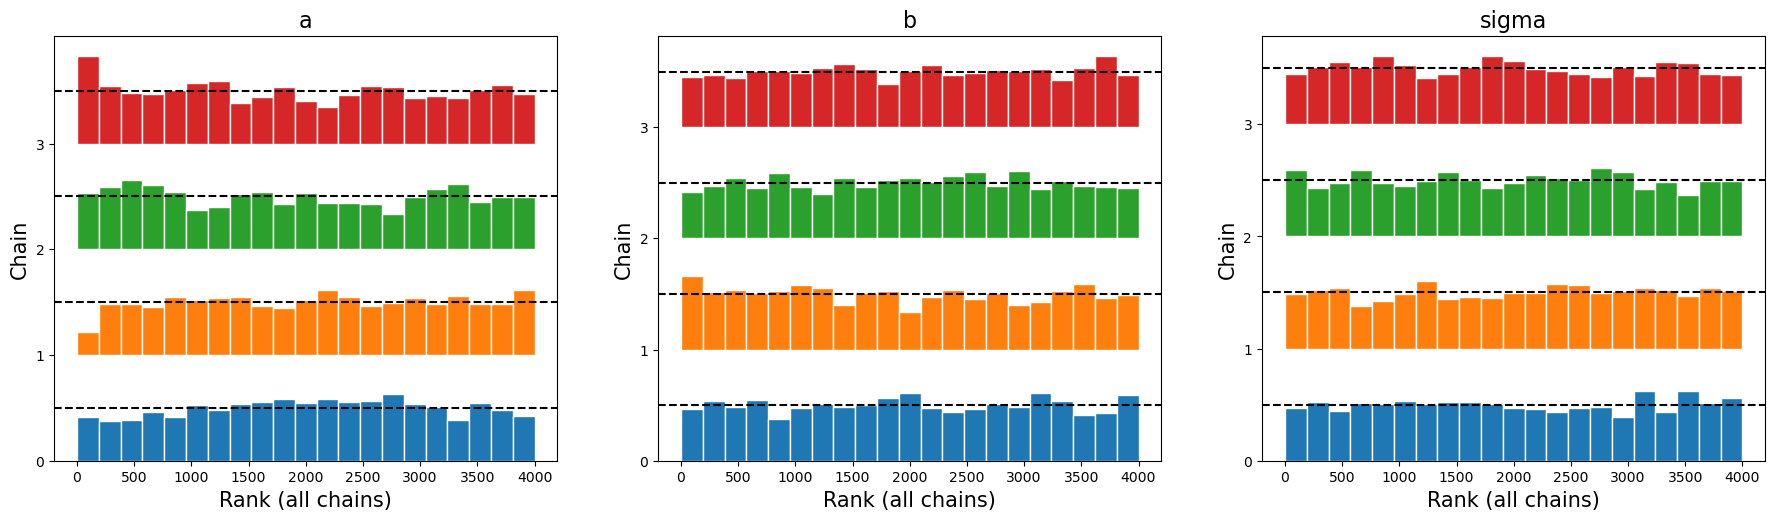

In [219]:
az.plot_rank(inference_1, var_names=['a', 'b', 'sigma'])

In [220]:
with model_1:
    gdp_pred_1 = pm.sample_posterior_predictive(inference_1)

Sampling: [y]


Output()

In [221]:
print('Fitting quadratic model')
with pm.Model() as model_2:
    a = pm.Uniform('a', lower=0, upper=20)
    b = pm.Normal('b', mu=0, sigma=1)
    c = pm.Normal('c', mu=0, sigma=1)
    sigma = pm.HalfNormal('sigma', 5)
    mu = pm.Deterministic('mu', a + b * data_x + c * data_x**2)
    y = pm.Normal('y', mu=mu, sigma=sigma, observed=data_y)
    inference_2 = pm.sample(10000)
    pm.compute_log_likelihood(inference_2)
az.summary(inference_2, var_names="~mu")

Fitting quadratic model


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, c, sigma]


Output()

Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 5 seconds.


Output()

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,0.333,0.069,0.223,0.444,0.0,0.0,21191.0,19058.0,1.0
b,0.665,0.056,0.577,0.755,0.0,0.0,24360.0,24822.0,1.0
c,-0.337,0.054,-0.425,-0.253,0.0,0.0,20835.0,21614.0,1.0
sigma,0.396,0.032,0.343,0.445,0.0,0.0,27444.0,26032.0,1.0


array([<Axes: title={'center': 'a'}, xlabel='Rank (all chains)', ylabel='Chain'>,
       <Axes: title={'center': 'b'}, xlabel='Rank (all chains)', ylabel='Chain'>,
       <Axes: title={'center': 'c'}, xlabel='Rank (all chains)', ylabel='Chain'>,
       <Axes: title={'center': 'sigma'}, xlabel='Rank (all chains)', ylabel='Chain'>],
      dtype=object)

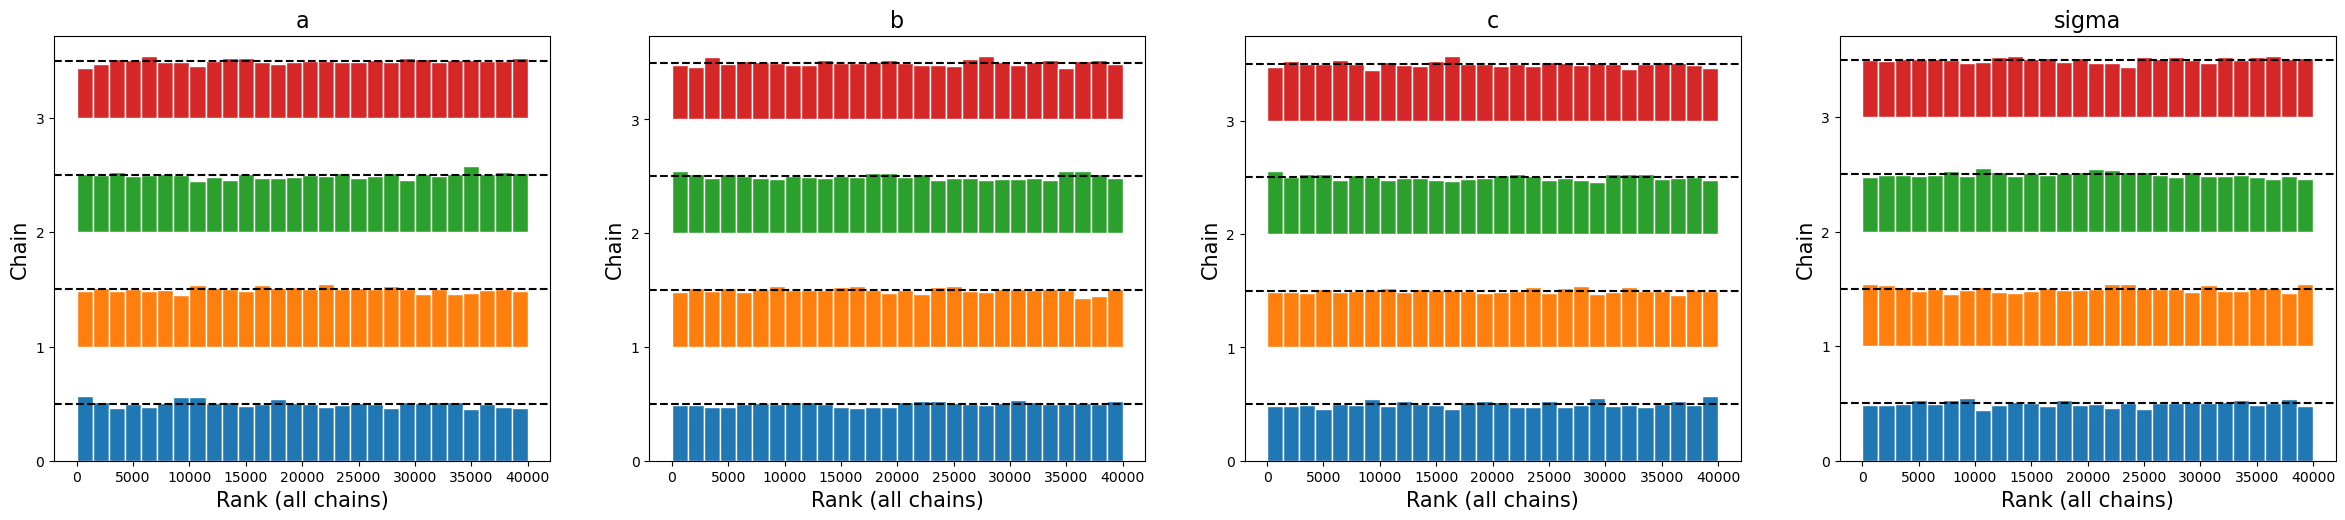

In [222]:
az.plot_rank(inference_2, var_names=['a', 'b', 'c', 'sigma'])

In [223]:
with model_2:
    gdp_pred_2 = pm.sample_posterior_predictive(inference_2)

Sampling: [y]


Output()

In [224]:
print('Fitting cubic model')
with pm.Model() as model_3:
    a = pm.Uniform('a', lower=0, upper=20)
    b = pm.Normal('b', mu=0, sigma=1)
    c = pm.Normal('c', mu=0, sigma=1)
    d = pm.Normal('d', mu=0, sigma=1)
    sigma = pm.HalfNormal('sigma', 5)
    mu = pm.Deterministic('mu', a + b * data_x + c * data_x**2 + d * data_x**3)
    y = pm.Normal('y', mu=mu, sigma=sigma, observed=data_y)
    inference_3 = pm.sample(10000)
    pm.compute_log_likelihood(inference_3)
az.summary(inference_3, var_names="~mu")

Fitting cubic model


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, c, d, sigma]


Output()

Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 8 seconds.


Output()

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,0.253,0.072,0.136,0.366,0.001,0.0,18661.0,16979.0,1.0
b,0.445,0.096,0.288,0.594,0.001,0.0,19859.0,21813.0,1.0
c,-0.153,0.084,-0.284,-0.018,0.001,0.0,15988.0,19995.0,1.0
d,0.163,0.058,0.070,0.256,0.000,0.0,16322.0,18613.0,1.0
sigma,0.380,0.031,0.330,0.429,0.000,0.0,25419.0,23279.0,1.0


array([[<Axes: title={'center': 'a'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'b'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'c'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<Axes: title={'center': 'd'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'sigma'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: >]], dtype=object)

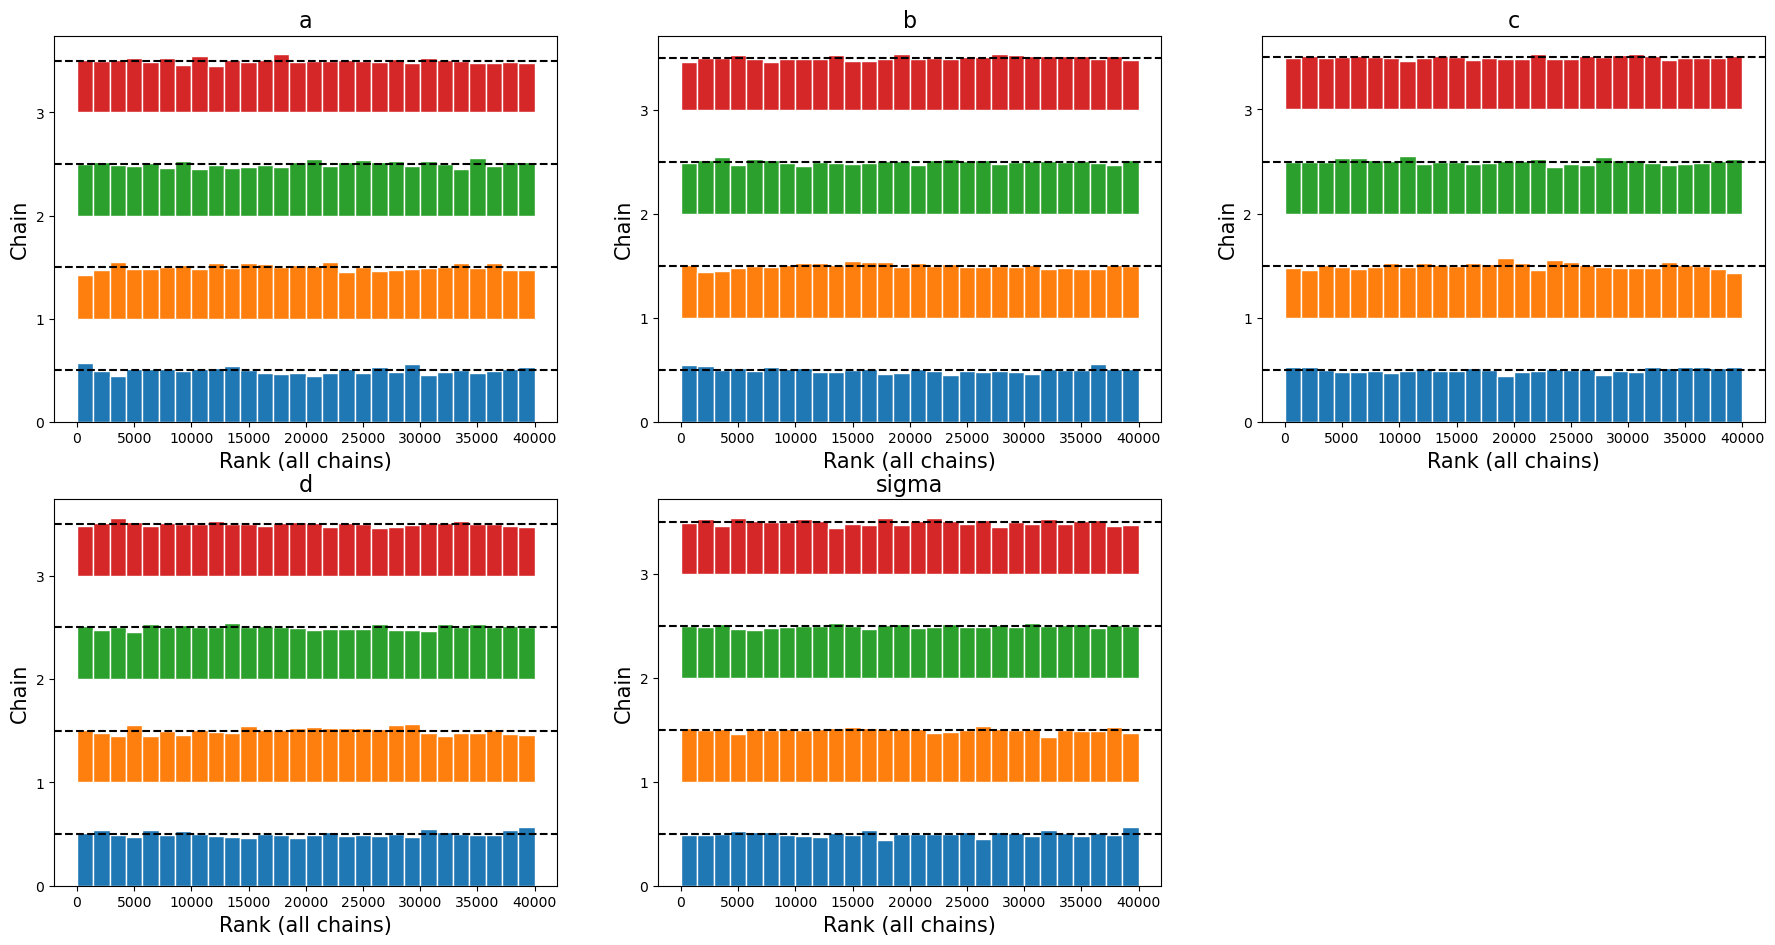

In [225]:
az.plot_rank(inference_3, var_names=['a', 'b', 'c', 'd', 'sigma'])

In [226]:
with model_3:
    gdp_pred_3 = pm.sample_posterior_predictive(inference_3)

Sampling: [y]


Output()

### Posterior Distribution

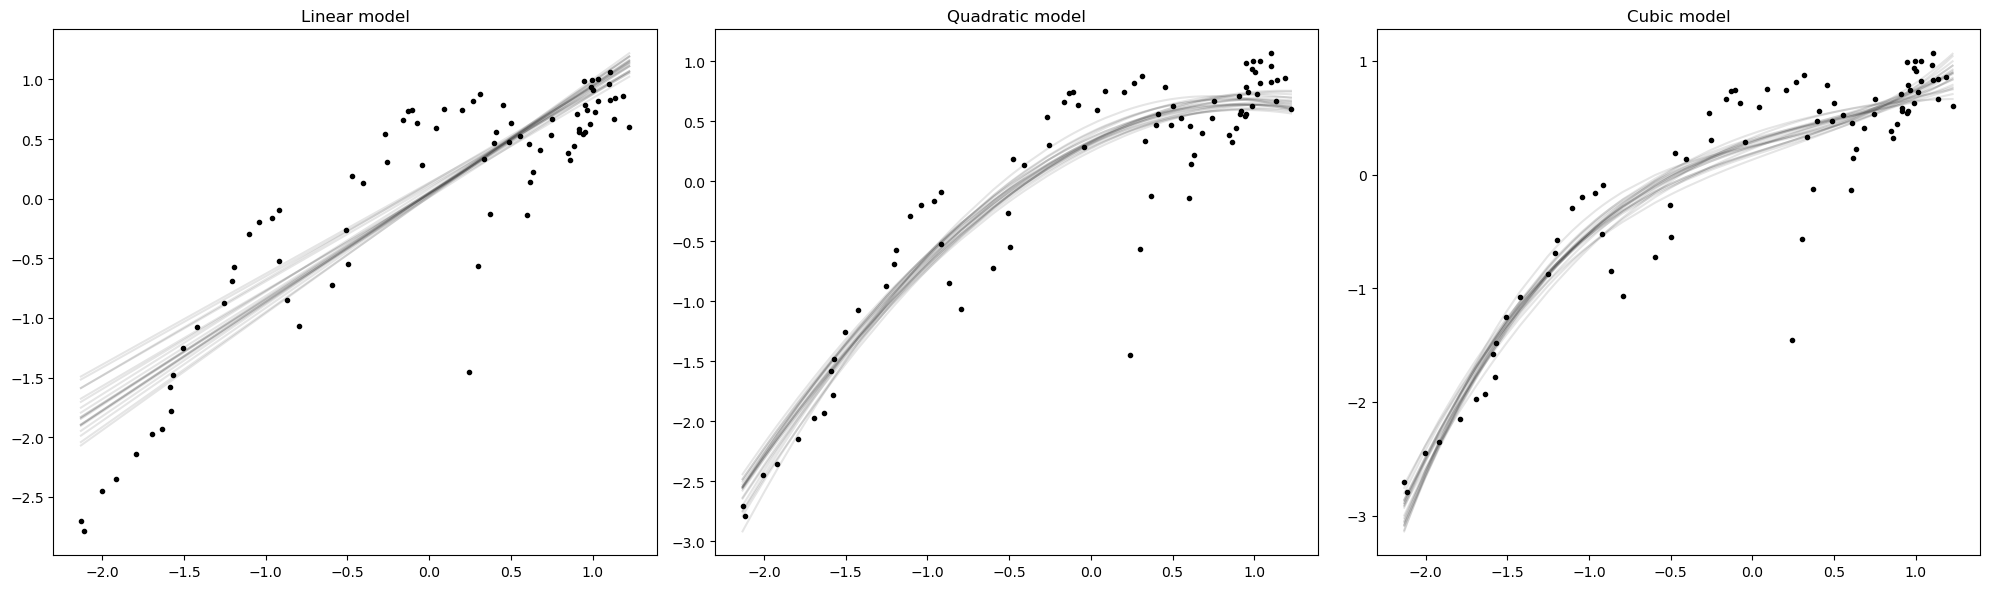

In [227]:
plt.figure(figsize=(20, 6))

# Linear model
plt.subplot(1, 3, 1)
plt.title('Linear model')
plt.plot(data_x, data_y, 'k.') 
plt.plot(data_x, inference_1.posterior.mu[0, :20, :].transpose(), 'k-', alpha=0.1)

# Quadratic model
plt.subplot(1, 3, 2)
plt.title('Quadratic model')
plt.plot(data_x, data_y, 'k.')
plt.plot(data_x, inference_2.posterior.mu[0, :20, :].transpose(), 'k-', alpha=0.1)

# Cubic model
plt.subplot(1, 3, 3) 
plt.title('Cubic model')
plt.plot(data_x, data_y, 'k.')
plt.plot(data_x, inference_3.posterior.mu[0, :20, :].transpose(), 'k-', alpha=0.1)
plt.tight_layout()
plt.show()

### Posterior-predictive Distribution

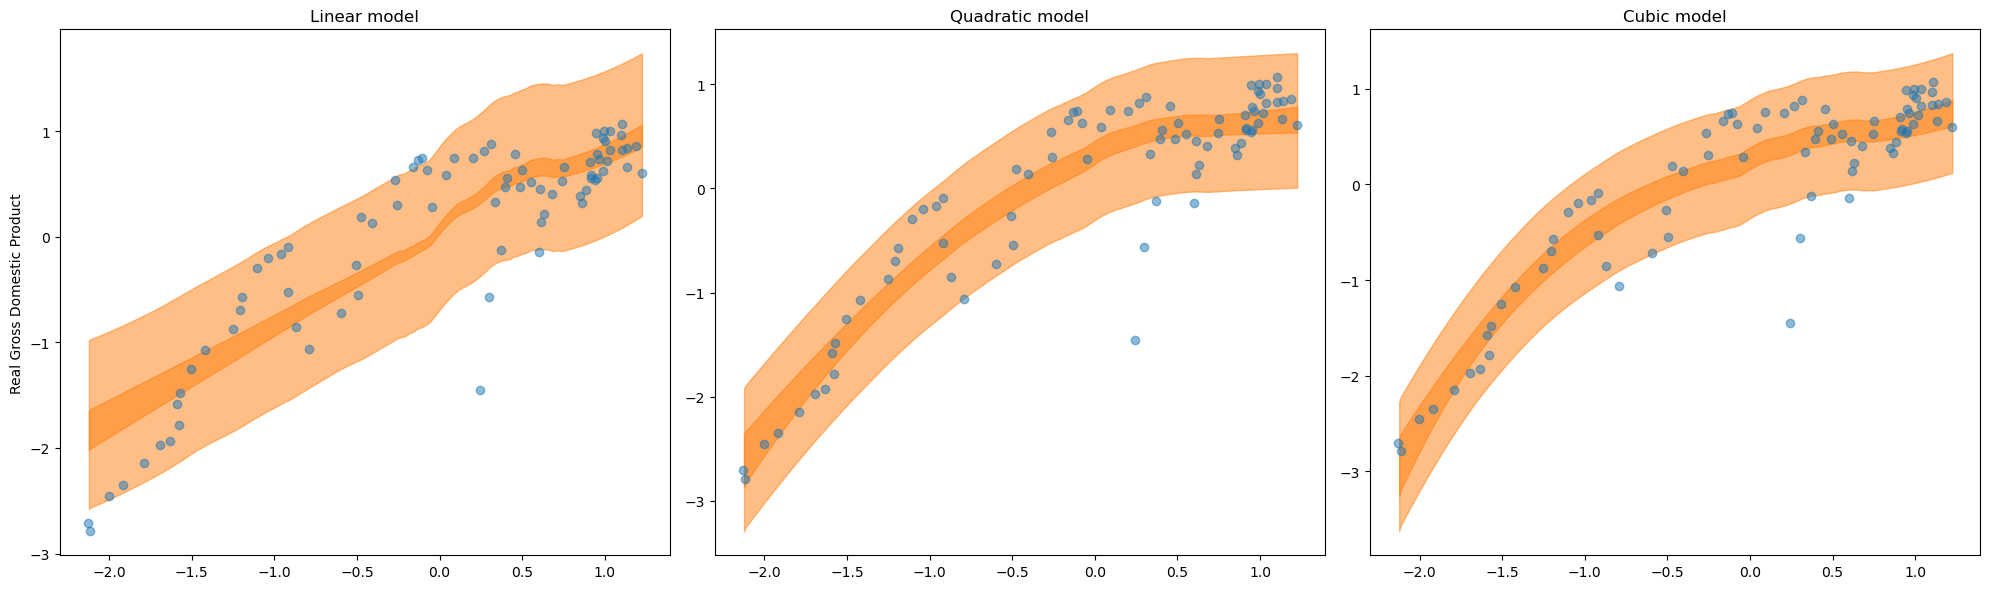

In [228]:
plt.figure(figsize=(20, 6))
az.rcParams["stats.ci_prob"] = 0.89

# Linear model
plt.subplot(1, 3, 1)
plt.title('Linear model')
ax1 = az.plot_hdi(df['gov_exp_std'], inference_1.posterior["mu"])
az.plot_hdi(df['gov_exp_std'], gdp_pred_1.posterior_predictive["y"])
plt.scatter(df['gov_exp_std'], df['gdp_std'], alpha=0.5)
plt.ylabel("Real Gross Domestic Product")

# Quadratic model
plt.subplot(1, 3, 2)
plt.title('Quadratic model')
ax2 = az.plot_hdi(df['gov_exp_std'], inference_2.posterior["mu"])
az.plot_hdi(df['gov_exp_std'], gdp_pred_2.posterior_predictive["y"])
plt.scatter(df['gov_exp_std'], df['gdp_std'], alpha=0.5)

# Cubic model
plt.subplot(1, 3, 3) 
plt.title('Cubic model')
ax3 = az.plot_hdi(df['gov_exp_std'], inference_3.posterior["mu"])
az.plot_hdi(df['gov_exp_std'], gdp_pred_3.posterior_predictive["y"])
plt.scatter(df['gov_exp_std'], df['gdp_std'], alpha=0.5)
plt.tight_layout()
plt.show()

### Model Comparison (PSIS & WAIC)

In [229]:
print('Model comparison with PSIS')
df = az.compare({'linear': inference_1, 'quadratic': inference_2, 'cubic': inference_3}, ic='loo')
df

Model comparison with PSIS


/Users/thananhthu/anaconda3/lib/python3.11/site-packages/arviz/stats/stats.py:792: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/Users/thananhthu/anaconda3/lib/python3.11/site-packages/arviz/stats/stats.py:792: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
cubic,0,-39.999177,7.217559,0.000000,0.922756,14.418335,0.000000,True,log
quadratic,1,-43.036344,6.550607,3.037167,0.000000,14.998618,2.150837,True,log
linear,2,-57.218822,2.736404,17.219645,0.077244,7.645025,8.748863,False,log


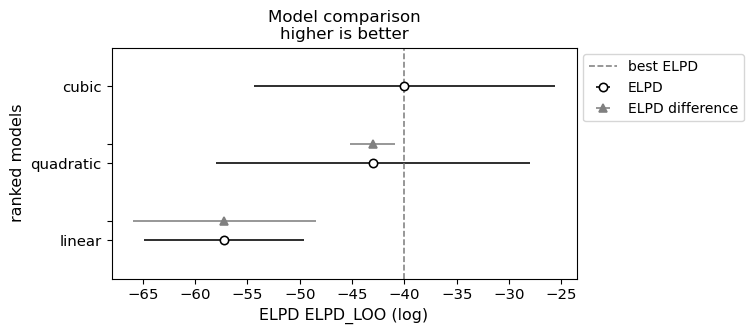

In [230]:
az.plot_compare(df)
plt.title('Model comparison\nhigher is better')
plt.xlabel('ELPD ' + df.columns[1].upper() + ' (log)')
plt.legend(['best ELPD', 'ELPD', 'ELPD difference', 'ELPD'], loc='upper left', bbox_to_anchor=(1.0, 1.0))
plt.show()

In [231]:
print('Model comparison with WAIC')
df = az.compare({'linear': inference_1, 'quadratic': inference_2, 'cubic': inference_3}, ic='waic')
df

Model comparison with WAIC


/Users/thananhthu/anaconda3/lib/python3.11/site-packages/arviz/stats/stats.py:1647: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/Users/thananhthu/anaconda3/lib/python3.11/site-packages/arviz/stats/stats.py:1647: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/Users/thananhthu/anaconda3/lib/python3.11/site-packages/arviz/stats/stats.py:1647: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


,rank,elpd_waic,p_waic,elpd_diff,weight,se,dse,warning,scale
cubic,0,-39.830331,7.048714,0.000000,0.922964,14.279892,0.000000,True,log
quadratic,1,-42.788775,6.303038,2.958445,0.000000,14.773884,2.124976,True,log
linear,2,-57.199154,2.716736,17.368823,0.077036,7.633713,8.637907,True,log


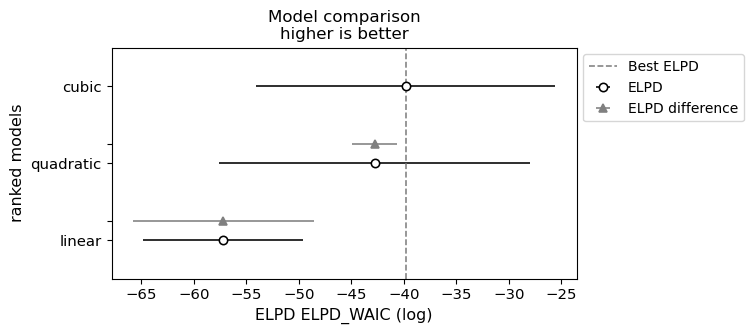

In [232]:
az.plot_compare(df)
# Add these labels since they are not in the latest release (scheduled for the next one)
plt.title('Model comparison\nhigher is better')
plt.xlabel('ELPD ' + df.columns[1].upper() + ' (log)')
plt.legend(['Best ELPD', 'ELPD', 'ELPD difference', 'ELPD'], loc='upper left', bbox_to_anchor=(1.0, 1.0))
plt.show()

# Student-T Likelihood

In [233]:
print('Fitting linear model')
with pm.Model() as model_1:
    a = pm.Uniform('a', lower=0, upper=20)
    b = pm.Normal('b', mu=0, sigma=1)
    sigma = pm.HalfNormal('sigma', 5)
    nu = pm.HalfNormal('nu', 30)
    mu = pm.Deterministic('mu', a + b * data_x)
    y = pm.StudentT('y', nu=nu, mu=mu, sigma=sigma, observed=data_y)
    inference_1t = pm.sample(tune=2000)
    pm.compute_log_likelihood(inference_1t)
az.summary(inference_1t, var_names="~mu")

Fitting linear model


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, sigma, nu]


Output()

Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 2 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


Output()

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,0.045,0.033,0.000,0.088,0.001,0.001,1346.0,644.0,1.0
b,0.868,0.054,0.782,0.956,0.001,0.001,2987.0,2566.0,1.0
nu,26.550,16.515,4.672,49.707,0.303,0.214,2562.0,2810.0,1.0
sigma,0.458,0.043,0.387,0.523,0.001,0.001,2482.0,1927.0,1.0


array([<Axes: title={'center': 'a'}, xlabel='Rank (all chains)', ylabel='Chain'>,
       <Axes: title={'center': 'b'}, xlabel='Rank (all chains)', ylabel='Chain'>],
      dtype=object)

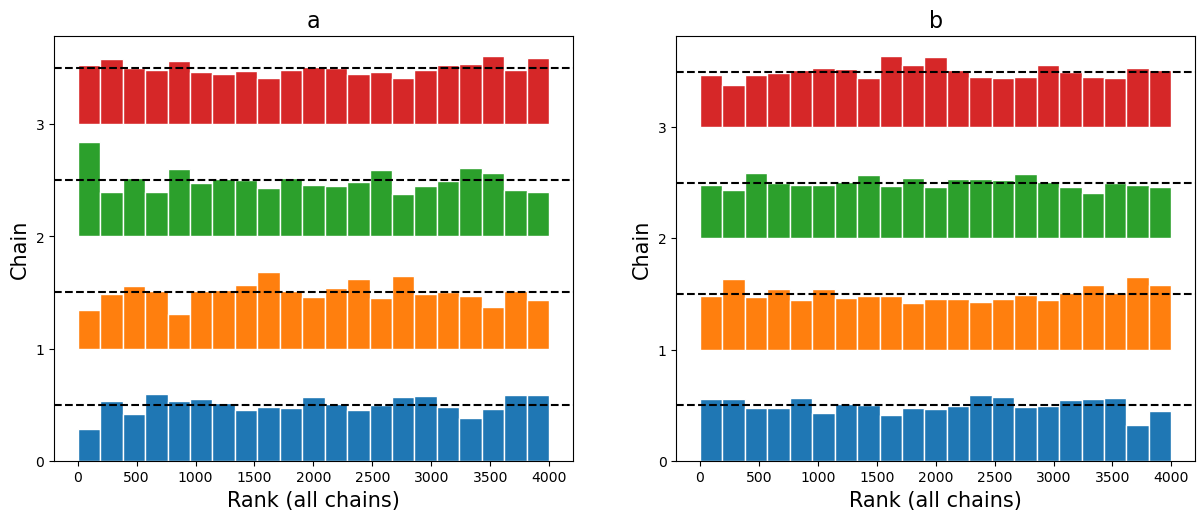

In [234]:
az.plot_rank(inference_1t, var_names=['a', 'b'])

In [235]:
print('Fitting quadratic model')
with pm.Model() as model_2:
    a = pm.Uniform('a', lower=0, upper=20)
    b = pm.Normal('b', mu=0, sigma=1)
    c = pm.Normal('c', mu=0, sigma=1)
    sigma = pm.HalfNormal('sigma', 5)
    nu = pm.HalfNormal('nu', 30)
    mu = pm.Deterministic('mu', a + b * data_x + c * data_x**2)
    y = pm.StudentT('y', nu=nu, mu=mu, sigma=sigma, observed=data_y)
    inference_2t = pm.sample(10000, tune=2000)
    pm.compute_log_likelihood(inference_2t)
az.summary(inference_2t, var_names="~mu")

Fitting quadratic model


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, c, sigma, nu]


Output()

Sampling 4 chains for 2_000 tune and 10_000 draw iterations (8_000 + 40_000 draws total) took 7 seconds.


Output()

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,0.440,0.067,0.335,0.549,0.001,0.000,15917.0,18541.0,1.0
b,0.643,0.047,0.567,0.715,0.000,0.000,19137.0,23540.0,1.0
c,-0.393,0.046,-0.468,-0.323,0.000,0.000,15903.0,19953.0,1.0
nu,6.110,4.531,1.854,10.232,0.034,0.024,20098.0,19733.0,1.0
sigma,0.283,0.039,0.219,0.343,0.000,0.000,19706.0,22165.0,1.0


array([<Axes: title={'center': 'a'}, xlabel='Rank (all chains)', ylabel='Chain'>,
       <Axes: title={'center': 'b'}, xlabel='Rank (all chains)', ylabel='Chain'>,
       <Axes: title={'center': 'c'}, xlabel='Rank (all chains)', ylabel='Chain'>],
      dtype=object)

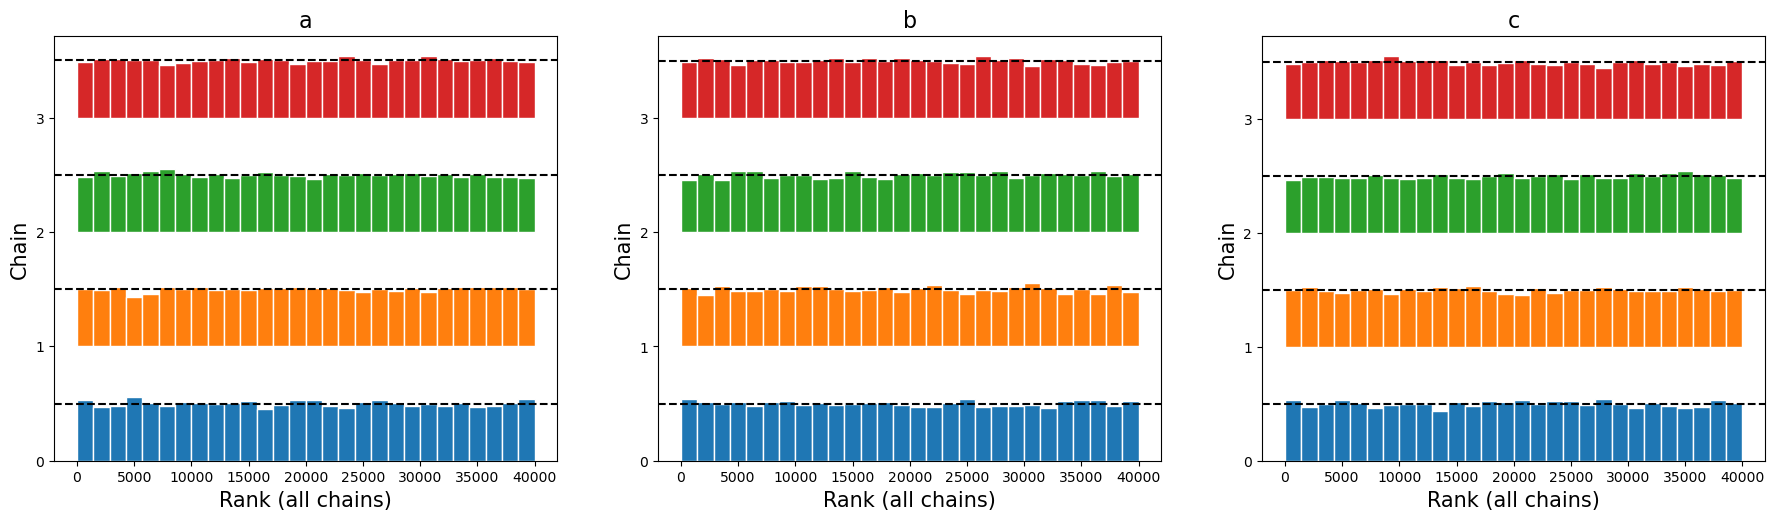

In [155]:
az.plot_rank(inference_2t, var_names=['a', 'b', 'c'])

In [236]:
print('Fitting cubic model')
with pm.Model() as model_3:
    a = pm.Uniform('a', lower=0, upper=20)
    b = pm.Normal('b', mu=0, sigma=1)
    c = pm.Normal('c', mu=0, sigma=1)
    d = pm.Normal('d', mu=0, sigma=1)
    sigma = pm.HalfNormal('sigma', 5)
    nu = pm.HalfNormal('nu', 30)
    mu = pm.Deterministic('mu', a + b * data_x + c * data_x**2 + d * data_x**3)
    y = pm.StudentT('y', nu=nu, mu=mu, sigma=sigma, observed=data_y)
    inference_3t = pm.sample(10000, tune=2000)
    pm.compute_log_likelihood(inference_3t)
az.summary(inference_3t, var_names="~mu")

Fitting cubic model


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, c, d, sigma, nu]


Output()

Sampling 4 chains for 2_000 tune and 10_000 draw iterations (8_000 + 40_000 draws total) took 13 seconds.


Output()

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,0.379,0.070,0.267,0.492,0.001,0.000,17065.0,16455.0,1.0
b,0.449,0.079,0.327,0.580,0.001,0.000,20520.0,22916.0,1.0
c,-0.245,0.070,-0.358,-0.135,0.001,0.000,16033.0,18625.0,1.0
d,0.133,0.048,0.059,0.210,0.000,0.000,17460.0,20394.0,1.0
nu,5.584,4.392,1.671,9.429,0.036,0.026,18836.0,16881.0,1.0
sigma,0.263,0.039,0.202,0.326,0.000,0.000,19001.0,21555.0,1.0


array([<Axes: title={'center': 'a'}, xlabel='Rank (all chains)', ylabel='Chain'>,
       <Axes: title={'center': 'b'}, xlabel='Rank (all chains)', ylabel='Chain'>,
       <Axes: title={'center': 'c'}, xlabel='Rank (all chains)', ylabel='Chain'>,
       <Axes: title={'center': 'd'}, xlabel='Rank (all chains)', ylabel='Chain'>],
      dtype=object)

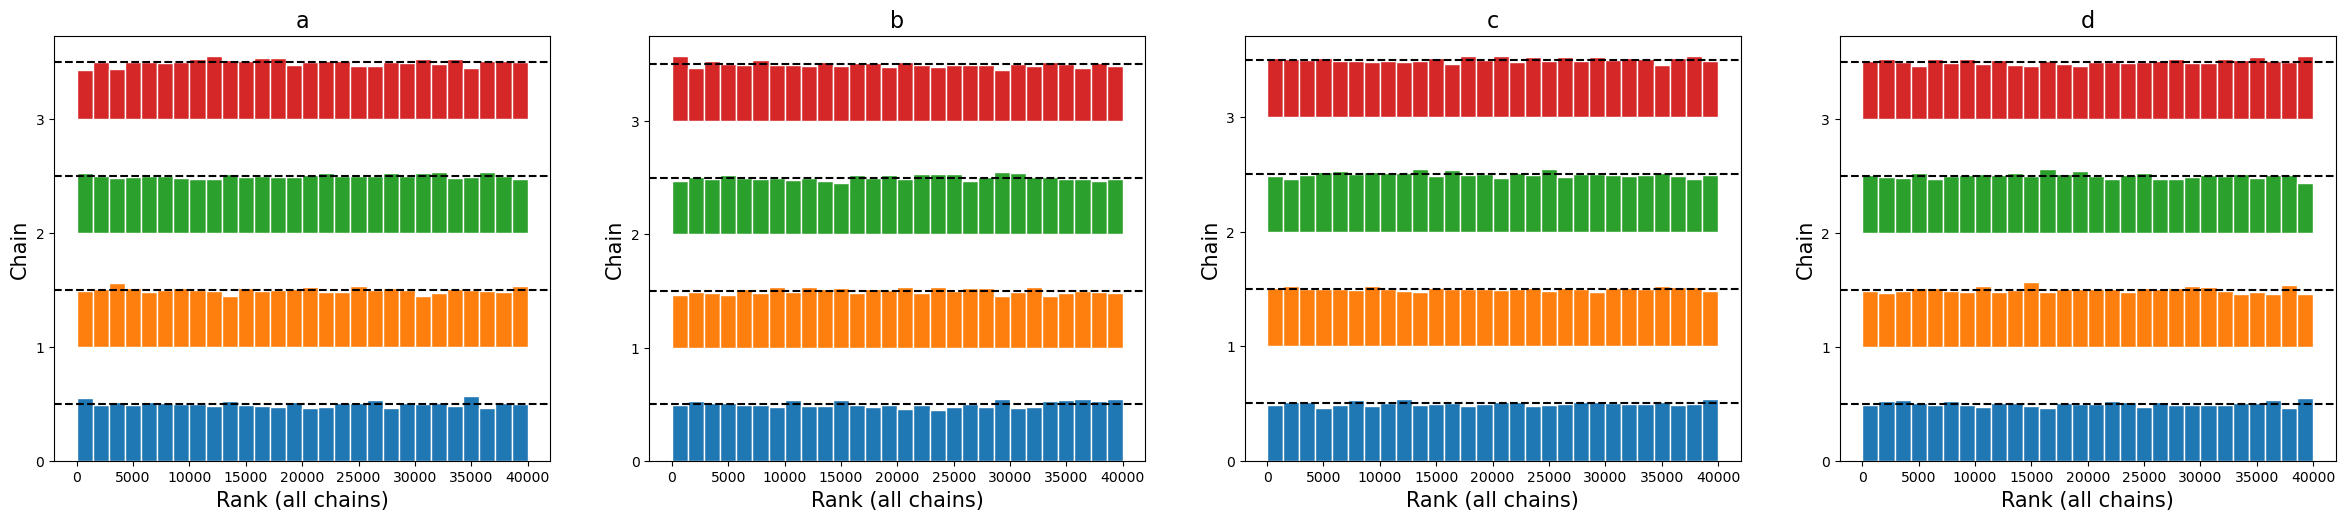

In [237]:
az.plot_rank(inference_3t, var_names=['a', 'b', 'c', 'd'])

### Posterior Distribution

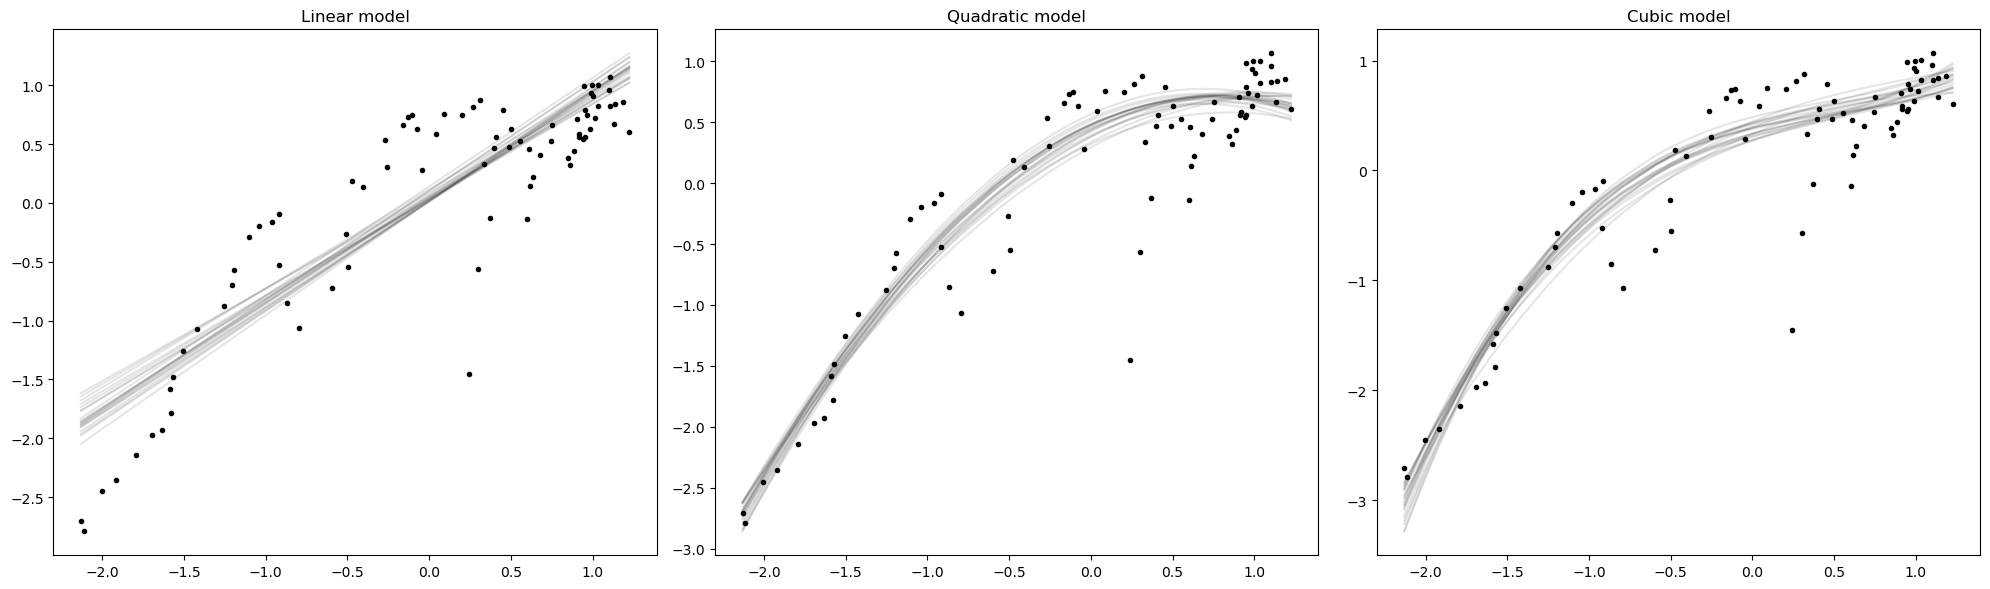

In [238]:
plt.figure(figsize=(20, 6))

# Linear model
plt.subplot(1, 3, 1)
plt.title('Linear model')
plt.plot(data_x, data_y, 'k.')
plt.plot(data_x, inference_1t.posterior.mu[0, :20, :].transpose(), 'k-', alpha=0.1)

# Quadratic model
plt.subplot(1, 3, 2)
plt.title('Quadratic model')
plt.plot(data_x, data_y, 'k.')
plt.plot(data_x, inference_2t.posterior.mu[0, :20, :].transpose(), 'k-', alpha=0.1)

# Cubic model
plt.subplot(1, 3, 3) 
plt.title('Cubic model')
plt.plot(data_x, data_y, 'k.')
plt.plot(data_x, inference_3t.posterior.mu[0, :20, :].transpose(), 'k-', alpha=0.1)
plt.tight_layout()
plt.show()

In [239]:
with model_1:
    gdp_pred_1t = pm.sample_posterior_predictive(inference_1t)

Sampling: [y]


Output()

In [240]:
with model_2:
    gdp_pred_2t = pm.sample_posterior_predictive(inference_2t)

Sampling: [y]


Output()

In [241]:
with model_3:
    gdp_pred_3t = pm.sample_posterior_predictive(inference_3t)

Sampling: [y]


Output()

### Posterior-predictive Distribution

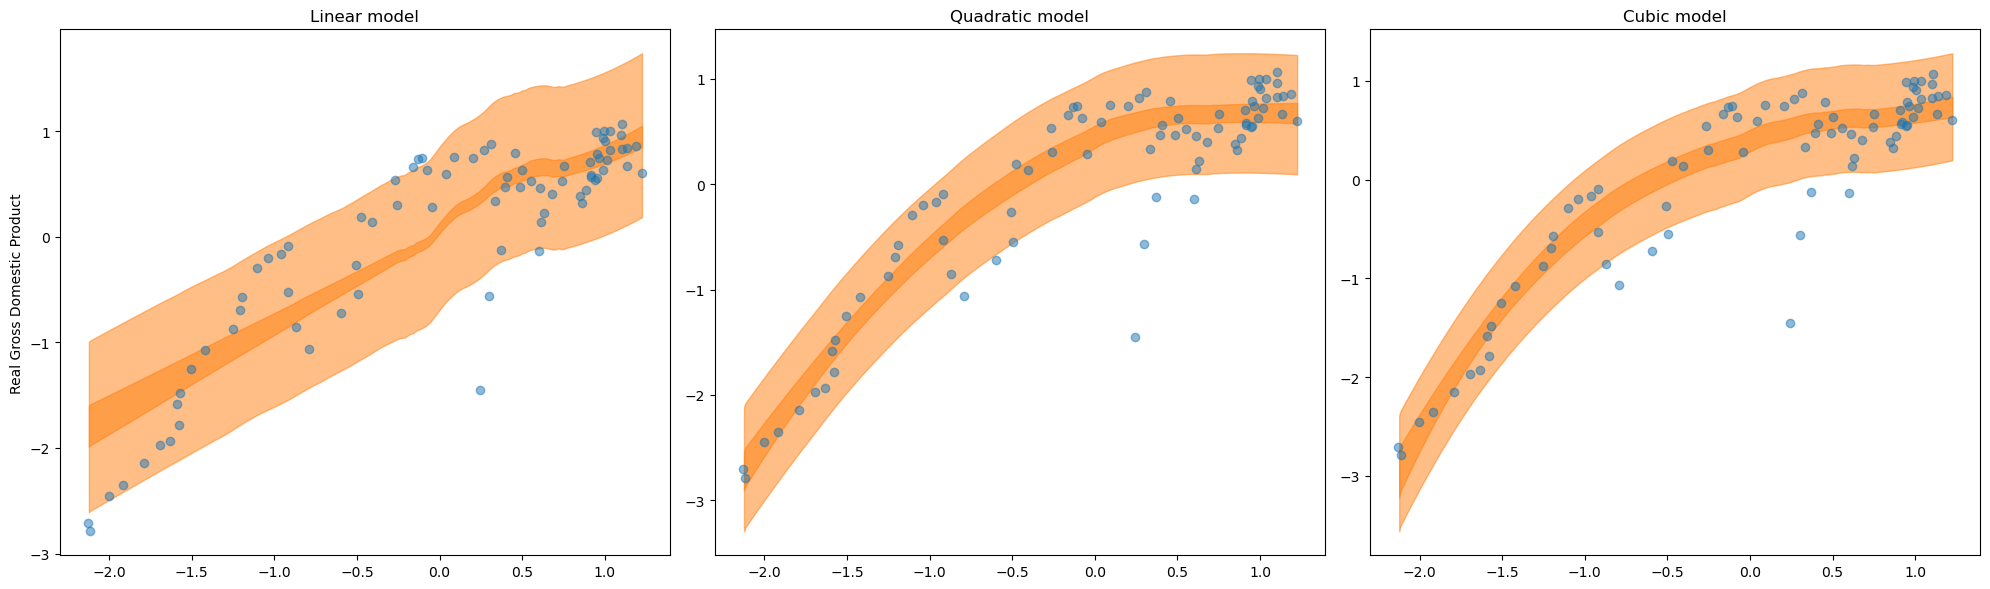

In [245]:
plt.figure(figsize=(20, 6))
az.rcParams["stats.ci_prob"] = 0.89

# Linear model
plt.subplot(1, 3, 1)
plt.title('Linear model')
ax1 = az.plot_hdi(df['gov_exp_std'], inference_1t.posterior["mu"])
az.plot_hdi(df['gov_exp_std'], gdp_pred_1t.posterior_predictive["y"])
plt.scatter(df['gov_exp_std'], df['gdp_std'], alpha=0.5)
plt.ylabel("Real Gross Domestic Product")

# Quadratic model
plt.subplot(1, 3, 2)
plt.title('Quadratic model')
ax2 = az.plot_hdi(df['gov_exp_std'], inference_2t.posterior["mu"])
az.plot_hdi(df['gov_exp_std'], gdp_pred_2t.posterior_predictive["y"])
plt.scatter(df['gov_exp_std'], df['gdp_std'], alpha=0.5)

# Cubic model
plt.subplot(1, 3, 3) 
plt.title('Cubic model')
ax3 = az.plot_hdi(df['gov_exp_std'], inference_3t.posterior["mu"])
az.plot_hdi(df['gov_exp_std'], gdp_pred_3t.posterior_predictive["y"])
plt.scatter(df['gov_exp_std'], df['gdp_std'], alpha=0.5)
plt.tight_layout()
plt.show()

### Model Comparison

In [246]:
print('Model comparison with PSIS')
df = az.compare({'linear': inference_1t, 'quadratic': inference_2t, 'cubic': inference_3t}, ic='loo')
df

Model comparison with PSIS


/Users/thananhthu/anaconda3/lib/python3.11/site-packages/arviz/stats/stats.py:792: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/Users/thananhthu/anaconda3/lib/python3.11/site-packages/arviz/stats/stats.py:792: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
cubic,0,-31.436680,7.477468,0.000000,0.902861,10.817704,0.000000,True,log
quadratic,1,-34.346885,6.224272,2.910205,0.000000,10.848879,2.608792,True,log
linear,2,-57.061952,2.860759,25.625272,0.097139,7.237638,7.671172,False,log


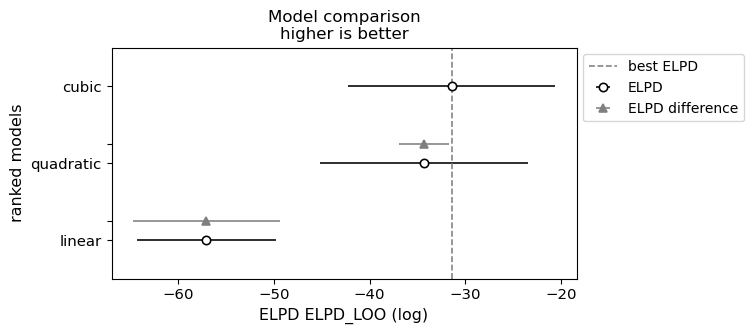

In [247]:
az.plot_compare(df)
plt.title('Model comparison\nhigher is better')
plt.xlabel('ELPD ' + df.columns[1].upper() + ' (log)')
plt.legend(['best ELPD', 'ELPD', 'ELPD difference', 'ELPD'], loc='upper left', bbox_to_anchor=(1.0, 1.0))
plt.show()

In [248]:
print('Model comparison with WAIC')
df = az.compare({'linear': inference_1t, 'quadratic': inference_2t, 'cubic': inference_3t}, ic='waic')
df

Model comparison with WAIC


/Users/thananhthu/anaconda3/lib/python3.11/site-packages/arviz/stats/stats.py:1647: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/Users/thananhthu/anaconda3/lib/python3.11/site-packages/arviz/stats/stats.py:1647: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/Users/thananhthu/anaconda3/lib/python3.11/site-packages/arviz/stats/stats.py:1647: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


,rank,elpd_waic,p_waic,elpd_diff,weight,se,dse,warning,scale
cubic,0,-30.951997,6.992785,0.000000,0.913371,10.491024,0.000000,True,log
quadratic,1,-33.923585,5.800972,2.971588,0.000000,10.533498,2.606603,True,log
linear,2,-57.049870,2.848678,26.097873,0.086629,7.234023,7.535453,True,log


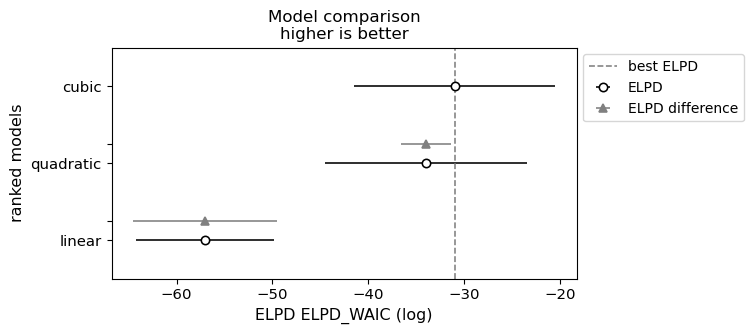

In [249]:
az.plot_compare(df)
plt.title('Model comparison\nhigher is better')
plt.xlabel('ELPD ' + df.columns[1].upper() + ' (log)')
plt.legend(['best ELPD', 'ELPD', 'ELPD difference', 'ELPD'], loc='upper left', bbox_to_anchor=(1.0, 1.0))
plt.show()

### Model Comparison (Normal vs. Student's t)

In [250]:
print('Model comparison with PSIS')
df = az.compare(
    {'Normal quadratic': inference_2,
     'Normal cubic': inference_3,
     'Student-T quadratic': inference_2t,
     'Student-T cubic': inference_3t
    }, 
    ic='loo')
df

Model comparison with PSIS


/Users/thananhthu/anaconda3/lib/python3.11/site-packages/arviz/stats/stats.py:792: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/Users/thananhthu/anaconda3/lib/python3.11/site-packages/arviz/stats/stats.py:792: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/Users/thananhthu/anaconda3/lib/python3.11/site-pack

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
Student-T cubic,0,-31.436680,7.477468,0.000000,8.903098e-01,10.817704,0.000000,True,log
Student-T quadratic,1,-34.346885,6.224272,2.910205,6.759136e-17,10.848879,2.608792,True,log
Normal cubic,2,-39.999177,7.217559,8.562497,1.362027e-02,14.418335,6.395996,True,log
Normal quadratic,3,-43.036344,6.550607,11.599664,9.606994e-02,14.998618,7.254856,True,log


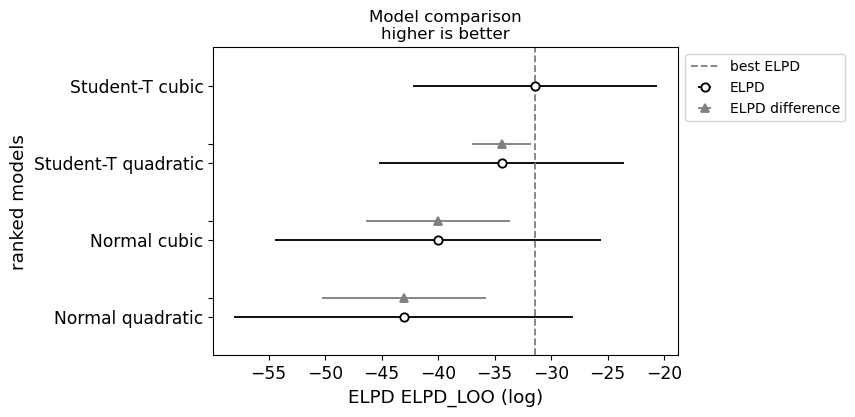

In [251]:
az.plot_compare(df)
plt.title('Model comparison\nhigher is better')
plt.xlabel('ELPD ' + df.columns[1].upper() + ' (log)')
plt.legend(['best ELPD', 'ELPD', 'ELPD difference', 'ELPD'], loc='upper left', bbox_to_anchor=(1.0, 1.0))
plt.show()

In [252]:
print('Model comparison with WAIC')
df = az.compare(
    {'Normal quadratic': inference_2,
     'Normal cubic': inference_3,
     'Student-T quadratic': inference_2t,
     'Student-T cubic': inference_3t
    }, 
    ic='waic')
df

Model comparison with WAIC


/Users/thananhthu/anaconda3/lib/python3.11/site-packages/arviz/stats/stats.py:1647: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/Users/thananhthu/anaconda3/lib/python3.11/site-packages/arviz/stats/stats.py:1647: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/Users/thananhthu/anaconda3/lib/python3.11/site-packages/arviz/stats/stats.py:1647: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/Users/thananhthu/anaconda3/lib/python3.11/site-packages/arviz/stats/stats.py:1647

,rank,elpd_waic,p_waic,elpd_diff,weight,se,dse,warning,scale
Student-T cubic,0,-30.951997,6.992785,0.000000,8.910068e-01,10.491024,0.000000,True,log
Student-T quadratic,1,-33.923585,5.800972,2.971588,2.816373e-16,10.533498,2.606603,True,log
Normal cubic,2,-39.830331,7.048714,8.878334,1.444344e-02,14.279892,6.657089,True,log
Normal quadratic,3,-42.788775,6.303038,11.836778,9.454973e-02,14.773884,7.430723,True,log


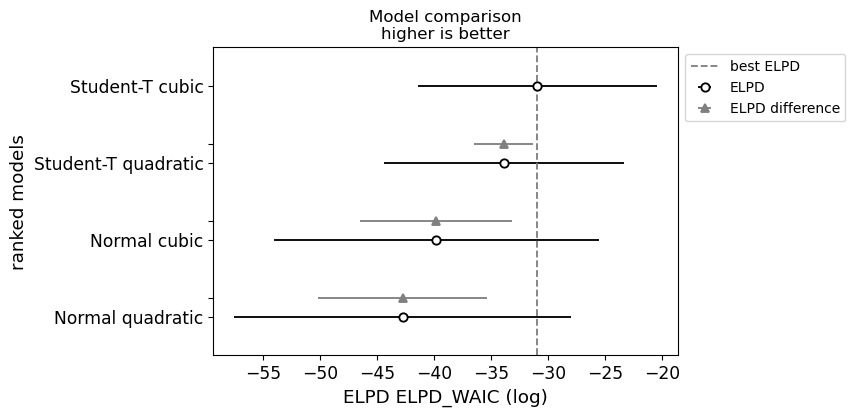

In [253]:
az.plot_compare(df)
plt.title('Model comparison\nhigher is better')
plt.xlabel('ELPD ' + df.columns[1].upper() + ' (log)')
plt.legend(['best ELPD', 'ELPD', 'ELPD difference', 'ELPD'], loc='upper left', bbox_to_anchor=(1.0, 1.0))
plt.show()

/Users/thananhthu/anaconda3/lib/python3.11/site-packages/arviz/stats/stats.py:792: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Pointwise PSIS: [-1.10724793e-01 -2.39706122e-01 -9.14832850e-02 -1.46276216e-01
 -1.77059509e-01 -1.74672916e-01 -2.77556895e-01 -1.95827626e-02
 -1.89333132e-01 -3.18000219e-02 -1.27345477e-01 -1.80966479e-01
 -9.17495017e-02 -2.48535039e-01 -4.67160043e-01 -9.18794772e-01
 -9.42576468e-01 -6.99885072e-01 -1.52542116e-02 -7.43870645e-01
 -4.21058702e-01 -1.46707502e+00 -9.83192021e-01 -1.13622068e-01
 -7.41046238e-01 -2.16806699e-01 -6.76887879e-02 -5.66394811e-01
 -1.00568625e-01 -6.73859938e-01 -8.17722928e-01 -8.04715609e-01
 -4.22844310e-01 -1.11368125e-02 -1.84059824e-01 -4.44603533e-01
 -2.85485780e-01 -1.46380637e+01 -3.67165137e-01 -3.93360720e+00
 -4.56738000e-01 -1.15260746e-01 -1.44744352e+00 -2.20557655e-02
 -4.86860012e-03 -1.67047004e-01 -3.96676236e-02 -1.13584669e-02
 -2.11621375e-02 -1.88222334e+00 -8.30893863e-02 -7.36612184e-01
 -5.24444292e-01 -1.67968937e-01 -4.44696252e-02 -5.67860981e-03
 -2.44382474e-01 -3.71154701e-01 -1.62363239e-01 -1.52373463e-02
 -3.92736

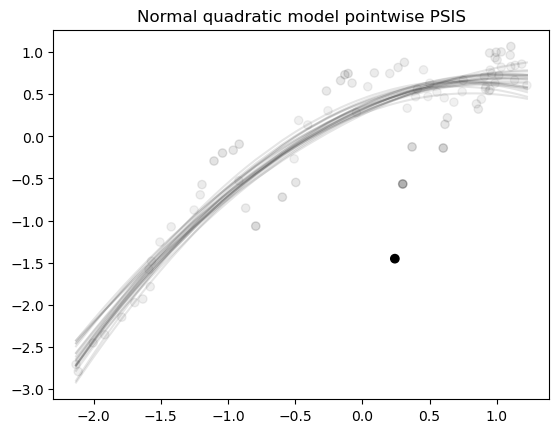

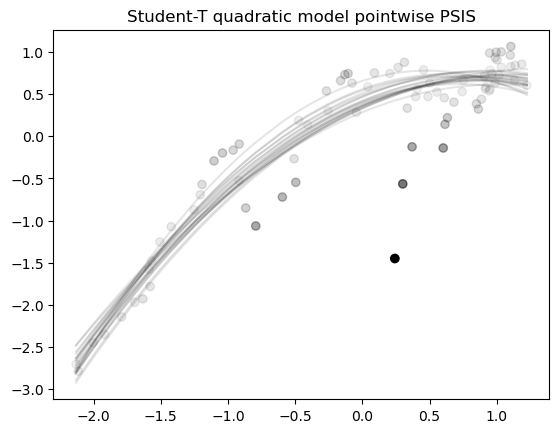

In [46]:
plt.figure()
plt.title('Normal quadratic model pointwise PSIS')
weights = az.loo(inference_2, pointwise=True).loo_i.values
print('Pointwise PSIS:', weights)
alpha = 1 - 0.95 * (weights - weights.min()) / (weights.max() - weights.min())
plt.scatter(data_x, data_y, color='black', alpha=alpha)
plt.plot(data_x, inference_2.posterior.mu[0, :20, :].transpose(), 'k-', alpha=0.1)

plt.figure()
plt.title('Student-T quadratic model pointwise PSIS')
weights = az.loo(inference_2t, pointwise=True).loo_i.values
print('Pointwise PSIS:', weights)
alpha = 1 - 0.95 * (weights - weights.min()) / (weights.max() - weights.min())
plt.scatter(data_x, data_y, color='black', alpha=alpha)
plt.plot(data_x, inference_2t.posterior.mu[0, :20, :].transpose(), 'k-', alpha=0.1)
plt.show()

/Users/thananhthu/anaconda3/lib/python3.11/site-packages/arviz/stats/stats.py:792: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Pointwise PSIS: [-4.38870060e-01 -1.68005926e-01 -9.18836119e-02 -1.69988987e-02
 -1.03668219e-01 -1.95376084e-01 -3.99566196e-01 -6.86379403e-03
 -3.37834054e-01  1.78098610e-02  3.55109208e-03 -6.72996639e-03
  1.89870216e-02 -1.71686874e-02 -1.30773632e-01 -4.40330095e-01
 -4.66315959e-01 -3.04490197e-01 -2.71843888e-02 -3.49112013e-01
 -8.89321666e-01 -2.31219989e+00 -1.39595234e+00 -1.68202205e-01
 -9.67800244e-01 -1.15120143e-01 -6.51792959e-03 -6.08039725e-01
 -8.41031033e-02 -8.31490960e-01 -1.03707877e+00 -1.04718683e+00
 -5.96196322e-01  2.12374041e-02 -3.40360227e-01 -7.48547140e-01
 -5.75325036e-01 -1.40543518e+01 -7.24110142e-01 -3.31721009e+00
 -8.72718609e-01  1.93559680e-02 -9.93378705e-01  1.97198582e-02
 -4.15506942e-02 -4.14836888e-01  3.06060796e-02 -7.59503381e-02
  2.60600518e-02 -1.45763412e+00  2.63670713e-02 -4.41493988e-01
 -2.74762239e-01 -2.55980375e-02  3.16689643e-02  3.40172918e-03
 -1.60092919e-01 -2.95703660e-01 -1.07182105e-01  2.39975411e-02
  2.38565

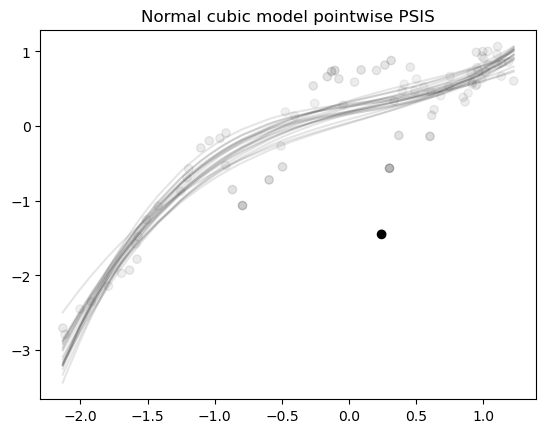

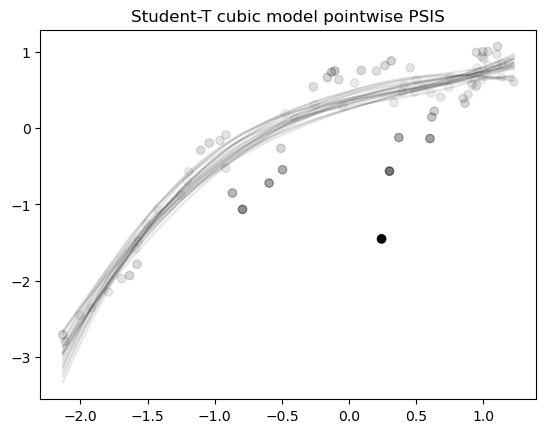

In [175]:
plt.figure()
plt.title('Normal cubic model pointwise PSIS')
weights = az.loo(inference_3, pointwise=True).loo_i.values
print('Pointwise PSIS:', weights)
alpha = 1 - 0.95 * (weights - weights.min()) / (weights.max() - weights.min())
plt.scatter(data_x, data_y, color='black', alpha=alpha)
plt.plot(data_x, inference_3.posterior.mu[0, :20, :].transpose(), 'k-', alpha=0.1)

plt.figure()
plt.title('Student-T cubic model pointwise PSIS')
weights = az.loo(inference_3t, pointwise=True).loo_i.values
print('Pointwise PSIS:', weights)
alpha = 1 - 0.95 * (weights - weights.min()) / (weights.max() - weights.min())
plt.scatter(data_x, data_y, color='black', alpha=alpha)
plt.plot(data_x, inference_3t.posterior.mu[0, :20, :].transpose(), 'k-', alpha=0.1)
plt.show()

# Outlier Detection

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [c0, c1, c2, c3, sigma, sigma_out, p]
>BinaryGibbsMetropolis: [is_outlier]


Output()

Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 34 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


Output()

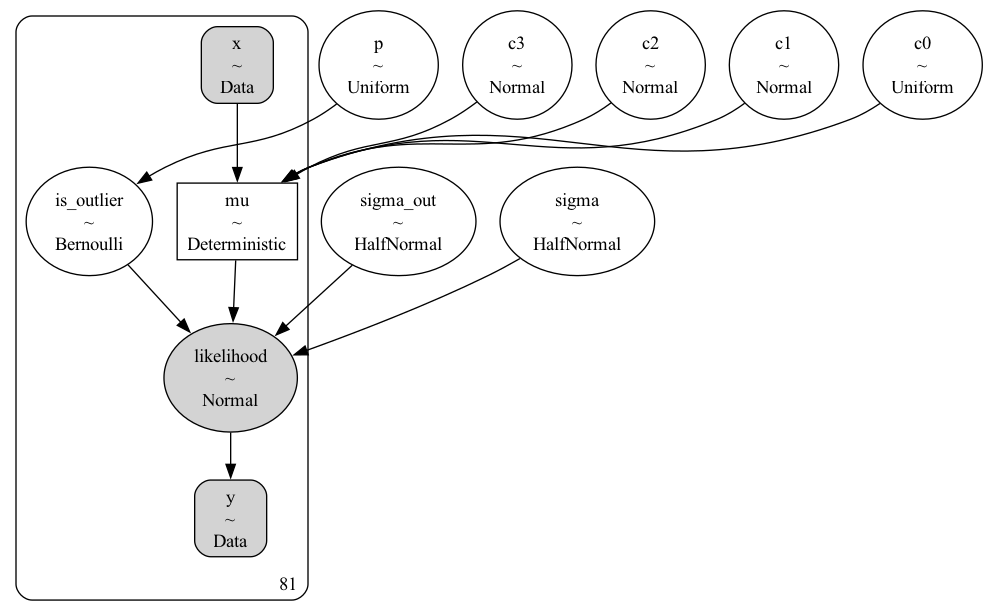

In [254]:
import pytensor.tensor as pt

with pm.Model() as outlier_model:

    # Observed variables
    x = pm.Data('x', data_x)
    y = pm.Data('y', data_y)

    # Linear regression
    c0 = pm.Uniform('c0', lower=0, upper=10)
    c1 = pm.Normal('c1', mu=0, sigma=1)
    c2 = pm.Normal('c2', mu=0, sigma=1)
    c3 = pm.Normal('c3', mu=0, sigma=1)
    mu = pm.Deterministic('mu', c0 + c1 * x + c2*x**2 + c3*x**3)

    # Noise parameters for inliers and outliers
    sigma = pm.HalfNormal('sigma', sigma=10)
    sigma_out = pm.HalfNormal('sigma_out', sigma=30)
    sigmas = pt.as_tensor_variable([sigma, sigma + sigma_out])

    # In/out class assignment probability and indicators
    p = pm.Uniform('p', lower=0, upper=0.2)
    is_outlier = pm.Bernoulli('is_outlier', p=p, size=x.shape[0])

    pm.Normal('likelihood', mu=mu, sigma=sigmas[is_outlier], observed=y)
    outlier_inference = pm.sample(10000, tune=1000)
    pm.compute_log_likelihood(outlier_inference)

from IPython.display import Image
Image(pm.model_to_graphviz(outlier_model).render(format='png'))

### Diagnostics

In [255]:
az.summary(outlier_inference, var_names="~mu")

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
c0,0.373,0.073,0.253,0.487,0.001,0.001,3939.0,12642.0,1.0
c1,0.469,0.080,0.341,0.595,0.001,0.001,11180.0,18087.0,1.0
c2,-0.250,0.070,-0.362,-0.138,0.001,0.001,7271.0,14984.0,1.0
c3,0.124,0.047,0.049,0.198,0.000,0.000,11631.0,16571.0,1.0
is_outlier[0],0.053,0.223,0.000,0.000,0.002,0.001,14806.0,14806.0,1.0
...,...,...,...,...,...,...,...,...,...
is_outlier[79],0.024,0.152,0.000,0.000,0.001,0.001,23856.0,23856.0,1.0
is_outlier[80],0.030,0.170,0.000,0.000,0.001,0.001,22136.0,22136.0,1.0
p,0.082,0.054,0.004,0.165,0.001,0.001,2244.0,7006.0,1.0
sigma,0.277,0.040,0.210,0.339,0.001,0.001,2723.0,6387.0,1.0


array([[<Axes: title={'center': 'c0'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'c1'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'sigma'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<Axes: title={'center': 'p'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'sigma_out'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: >]], dtype=object)

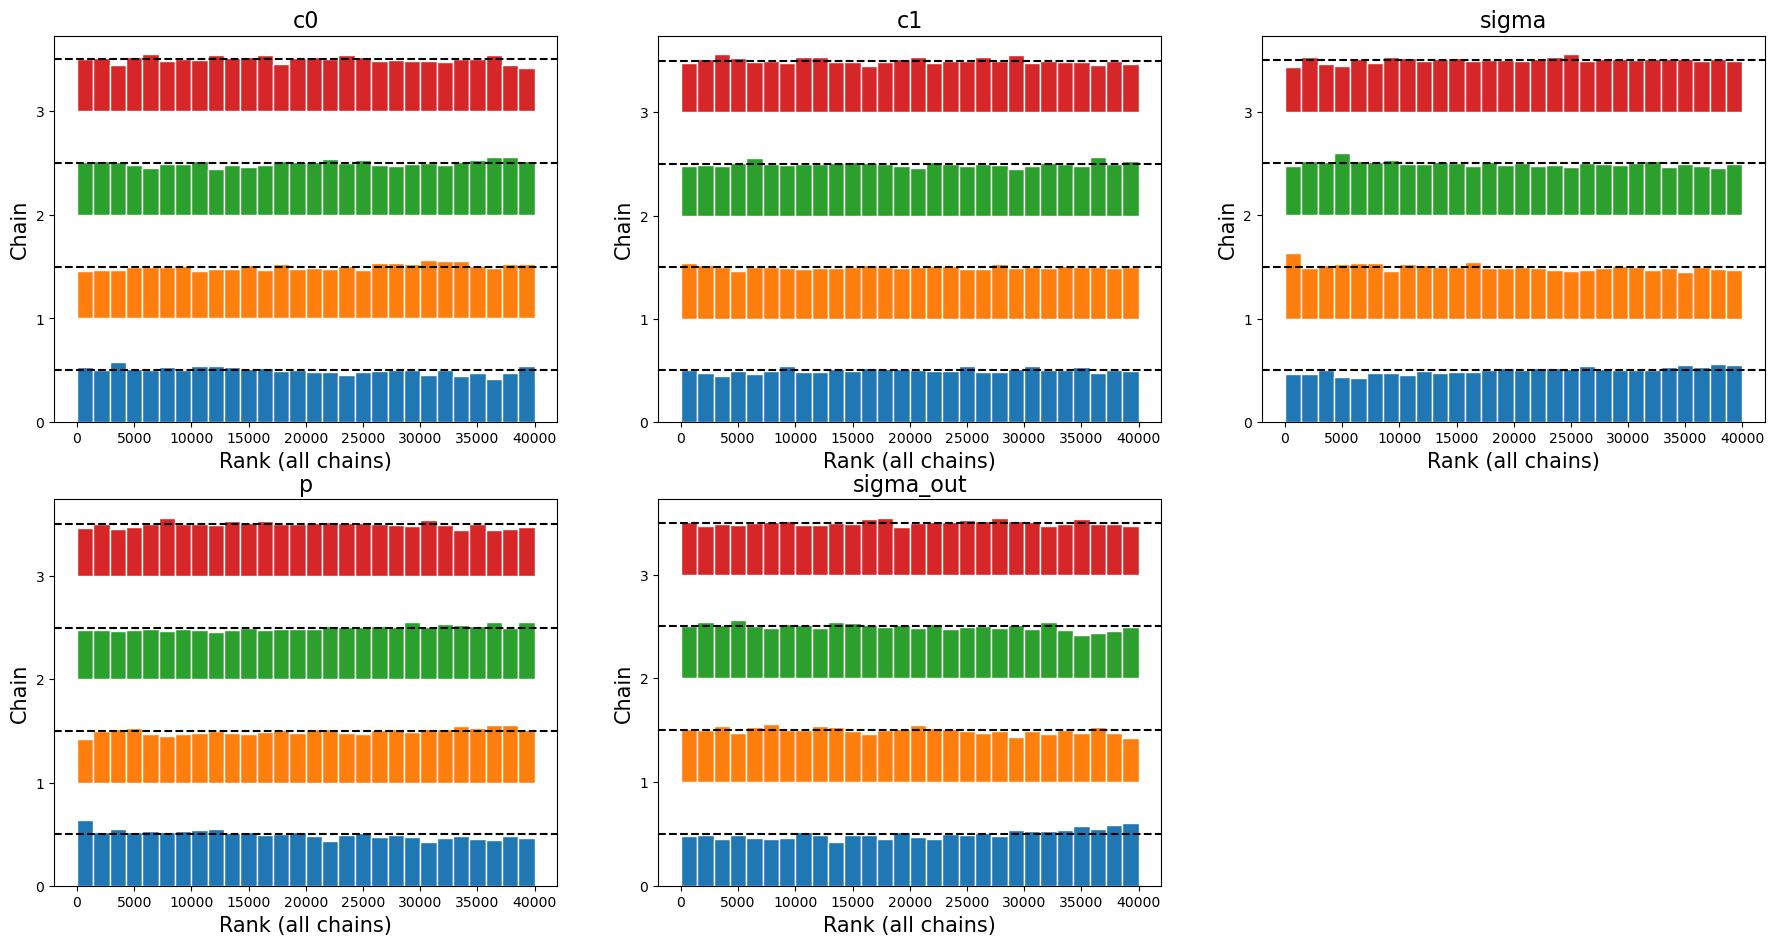

In [256]:
az.plot_rank(outlier_inference, var_names=['c0', 'c1', 'sigma', 'p', 'sigma_out'])

In [257]:
# Sample from the posterior predictive distribution
with outlier_model:
    gdp_outlier = pm.sample_posterior_predictive(outlier_inference)

Sampling: [likelihood]


Output()

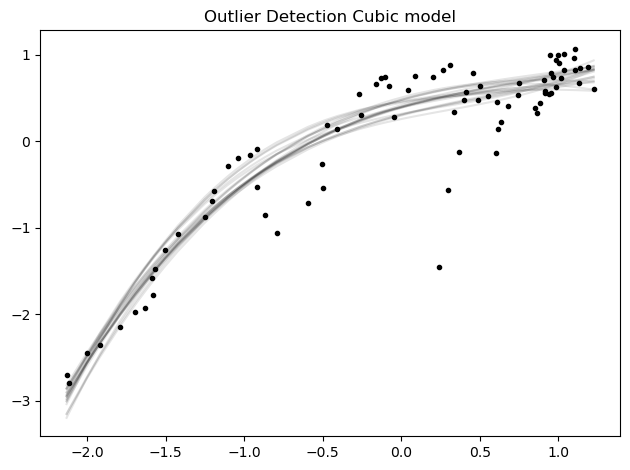

In [258]:
plt.title('Outlier Detection Cubic model')
plt.plot(data_x, data_y, 'k.')
plt.plot(data_x, outlier_inference.posterior.mu[0, :20, :].transpose(), 'k-', alpha=0.1)
plt.tight_layout()
plt.show()

/Users/thananhthu/anaconda3/lib/python3.11/site-packages/arviz/rcparams.py:345: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


Text(0, 0.5, 'Real Gross Domestic Product')

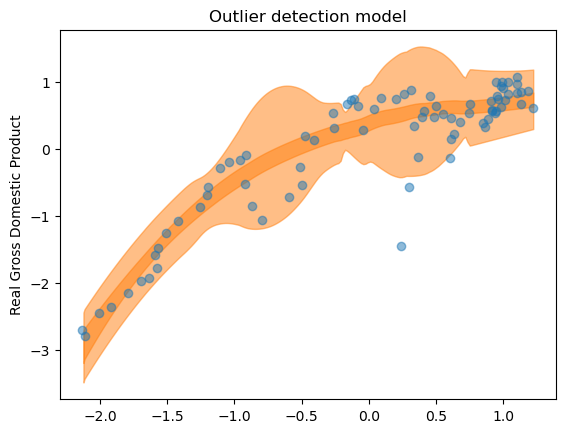

In [262]:
az.rcParams["stats.hdi_prob"] = 0.89

plt.title('Outlier detection model')
ax1 = az.plot_hdi(df['gov_exp_std'], outlier_inference.posterior["mu"])
az.plot_hdi(df['gov_exp_std'], gdp_outlier.posterior_predictive["likelihood"])
plt.scatter(df['gov_exp_std'], df['gdp_std'], alpha=0.5)
plt.ylabel("Real Gross Domestic Product")

### Model Comparison

In [263]:
print('Model comparison with PSIS')
df = az.compare({
    'Normal Cubic': inference_3, 
    'Student-t Cubic': inference_3t, 
    'Outlier Detection': outlier_inference}, 
    ic='loo')
df

Model comparison with PSIS


/Users/thananhthu/anaconda3/lib/python3.11/site-packages/arviz/stats/stats.py:792: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/Users/thananhthu/anaconda3/lib/python3.11/site-packages/arviz/stats/stats.py:792: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/Users/thananhthu/anaconda3/lib/python3.11/site-pack

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
Outlier Detection,0,-29.370846,16.447639,0.000000,0.730693,8.907741,0.000000,True,log
Student-t Cubic,1,-31.436680,7.477468,2.065833,0.000131,10.817704,3.988390,True,log
Normal Cubic,2,-39.999177,7.217559,10.628330,0.269176,14.418335,10.170099,True,log


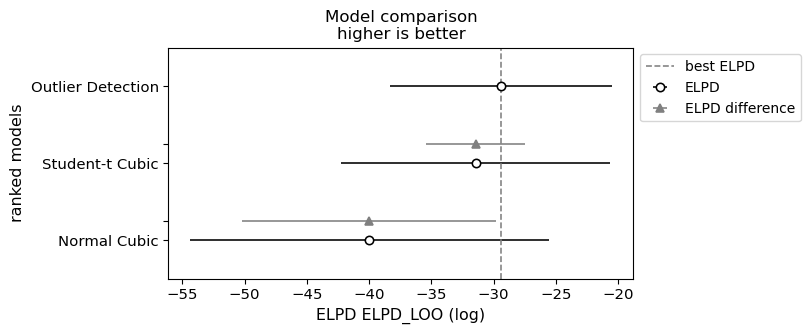

In [264]:
az.plot_compare(df)
plt.title('Model comparison\nhigher is better')
plt.xlabel('ELPD ' + df.columns[1].upper() + ' (log)')
plt.legend(['best ELPD', 'ELPD', 'ELPD difference', 'ELPD'], loc='upper left', bbox_to_anchor=(1.0, 1.0))
plt.show()

In [265]:
print('Model comparison with WAIC')
df = az.compare({
    'Normal Cubic': inference_3, 
    'Student-t Cubic': inference_3t, 
    'Outlier Detection': outlier_inference}, 
    ic='waic')
df

Model comparison with WAIC


/Users/thananhthu/anaconda3/lib/python3.11/site-packages/arviz/stats/stats.py:1647: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/Users/thananhthu/anaconda3/lib/python3.11/site-packages/arviz/stats/stats.py:1647: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/Users/thananhthu/anaconda3/lib/python3.11/site-packages/arviz/stats/stats.py:1647: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


,rank,elpd_waic,p_waic,elpd_diff,weight,se,dse,warning,scale
Outlier Detection,0,-27.554038,14.630831,0.000000,7.780494e-01,8.429926,0.000000,True,log
Student-t Cubic,1,-30.951997,6.992785,3.397959,4.354135e-17,10.491024,4.445817,True,log
Normal Cubic,2,-39.830331,7.048714,12.276293,2.219506e-01,14.279892,10.857042,True,log


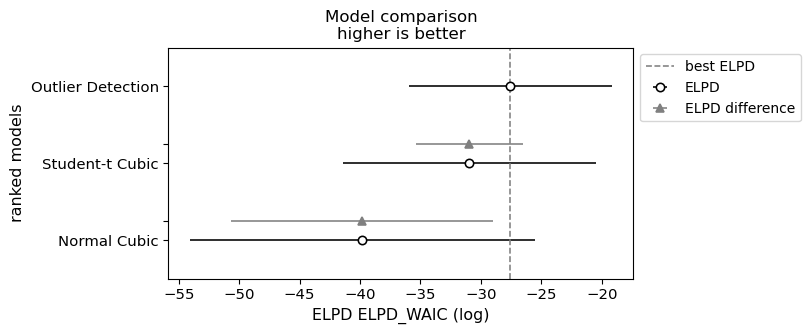

In [266]:
az.plot_compare(df)
# Add these labels since they are not in the latest release (scheduled for the next one)
plt.title('Model comparison\nhigher is better')
plt.xlabel('ELPD ' + df.columns[1].upper() + ' (log)')
plt.legend(['best ELPD', 'ELPD', 'ELPD difference', 'ELPD'], loc='upper left', bbox_to_anchor=(1.0, 1.0))
plt.show()